# L1 Bounding Box Detection Model

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os

import cv2

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import widgets, VBox, HBox

from IPython.display import display, clear_output

from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO

# Start from Fine Tuning Model section to only train model!!!

## Importing Images and Labels

### Image Labels

In [ ]:
train_labels = pd.read_csv('../../../data/Patch Perfect Data/train_labels.csv')
test_labels = pd.read_csv('../../../data/Patch Perfect Data/test_labels.csv')

In [ ]:
train_labels.shape

In [ ]:
test_labels.shape

In [ ]:
train_labels.head(3)

In [ ]:
train_labels['Bags used '].value_counts()

In [ ]:
train_labels.columns = ['pothole_id', 'bags_used']

In [ ]:
train_labels['pothole_id'] = 'p'+(train_labels['pothole_id']).astype('str')

In [ ]:
train_labels.head(3)

### Image annotations - bounding boxes

In [ ]:
def load_annotations(annotation_path):
    data = []
    for filename in os.listdir(annotation_path):
        if filename.endswith('.txt'):
            pothole_id = filename.split('.')[0]
            with open(os.path.join(annotation_path, filename), 'r') as file:
                lines = file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    data.append({
                        'pothole_id': pothole_id,
                        'class': int(parts[0]),
                        'x': float(parts[1]),
                        'y': float(parts[2]),
                        'width': float(parts[3]),
                        'height': float(parts[4])
                    })
    return pd.DataFrame(data)

In [ ]:
train_annotations = load_annotations('../../../data/Patch Perfect Data/train_annotations')

In [ ]:
train_annotations.head(3)

In [ ]:
train_annotations['class'].value_counts()

### Images

In [ ]:
def load_images_from_folder(folder):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                pothole_id = filename.split('.')[0]
                data.append({'pothole_id': pothole_id, 'image': img})
    return pd.DataFrame(data)

In [ ]:
train_images = load_images_from_folder('../../../data/Patch Perfect Data/train_images')
test_images = load_images_from_folder('../../../data/Patch Perfect Data/test_images')

In [ ]:
train_images.head(3)

## Visualising images

In [ ]:
def draw_bounding_boxes(image, annotations):
    for _, row in annotations.iterrows():
        img_height, img_width, _ = image.shape
        x_center = int(row['x'] * img_width)
        y_center = int(row['y'] * img_height)
        box_width = int(row['width'] * img_width)
        box_height = int(row['height'] * img_height)
        
        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)
        
        color = (0, 255, 0) if row['class'] == 0 else (255, 0, 0)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
    return image

In [ ]:
def convert_image_to_base64(image):
    _, buffer = cv2.imencode('.jpg', image)
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    buffered = BytesIO()
    pil_img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return "data:image/jpeg;base64," + img_str

In [ ]:
first_image_record = train_images.iloc[0]
first_image_id = first_image_record['pothole_id']
first_image = first_image_record['image']
first_image_annotations = train_annotations[train_annotations['pothole_id'] == first_image_id]
first_image_with_boxes = draw_bounding_boxes(first_image.copy(), first_image_annotations)
first_image_base64 = convert_image_to_base64(first_image_with_boxes)
first_image_label = train_labels[train_labels['pothole_id'] == first_image_id].iloc[:,1].values[0]

In [ ]:
fig = go.Figure()

# Add initial image
fig.add_trace(go.Image(source=first_image_base64))

# Generate dropdown options
dropdown_buttons = []
for pothole_id in train_images['pothole_id']:
    image = train_images[train_images['pothole_id'] == pothole_id].iloc[0]['image'].copy()
    annotations = train_annotations[train_annotations['pothole_id'] == pothole_id]
    image_with_boxes = draw_bounding_boxes(image, annotations)
    image_base64 = convert_image_to_base64(image_with_boxes)
    bags_used = train_labels[train_labels['pothole_id'] == pothole_id]['bags_used'].values

    dropdown_buttons.append({
        "args": [{"source": image_base64}, {"title": f"Image ID: {pothole_id} | Bags Used: {bags_used}"}],
        "label": pothole_id,
        "method": "update"
    })

# Update layout for dropdown
fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
        }
    ],
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    title=f"Image ID: {first_image_id} | Bags Used: {first_image_label}"
)

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

fig.show()

## Creating YOLO environment

In [ ]:
potholes_with_class_1 = set(train_annotations[train_annotations['class'] == 1]['pothole_id'])

annotations_with_class_1 = train_annotations[(train_annotations['pothole_id'].isin(potholes_with_class_1)) & (train_annotations['class'] == 1)]

train_images_with_class_1 = train_images[train_images['pothole_id'].isin(potholes_with_class_1)]

potholes_without_class_1 = set(train_annotations['pothole_id']) - potholes_with_class_1

annotations_without_class_1 = train_annotations[train_annotations['pothole_id'].isin(potholes_without_class_1)]

train_images_without_class_1 = train_images[train_images['pothole_id'].isin(potholes_without_class_1)]

In [ ]:
annotations_with_class_1['pothole_id'].value_counts().head()

In [ ]:
annotations_with_class_1_no_duplicates = annotations_with_class_1.drop_duplicates(subset=['pothole_id'], keep='first')

In [ ]:
annotations_with_class_1_no_duplicates.shape

In [ ]:
def convert_to_yolo_format(image, bboxes):
    """
    Convert bounding box data from your format (x, y, width, height) to YOLO format.
    """
    original_height, original_width = image.shape[:2]
    
    yolo_bboxes = []
    for bbox in bboxes:
        # The x and y in your data are already the center of the bounding box in normalized form
        x_center = bbox['x']
        y_center = bbox['y']
        width = bbox['width']
        height = bbox['height']
        
        yolo_bboxes.append(f"{bbox['class']-1} {x_center} {y_center} {width} {height}")
    
    return yolo_bboxes

In [ ]:
image_dir = 'YOLO/L1/images'  # or any directory where you want to save the images
label_dir = 'YOLO/L1/labels'  # directory where labels will be saved

os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# Save images and labels in YOLO format
for img, pothole_id in zip(train_images_with_class_1['image'], train_images_with_class_1['pothole_id']):
    # Get the bounding boxes for the current image
    bboxes = annotations_with_class_1_no_duplicates[annotations_with_class_1_no_duplicates['pothole_id'] == pothole_id].to_dict('records')
    
    # Save the image
    img_path = os.path.join(image_dir, f"{pothole_id}.jpg")
    cv2.imwrite(img_path, img)
    
    # Convert bounding boxes to YOLO format
    yolo_bboxes = convert_to_yolo_format(img, bboxes)
    
    # Save the annotations
    label_path = os.path.join(label_dir, f"{pothole_id}.txt")
    with open(label_path, 'w') as f:
        f.write("\n".join(yolo_bboxes))

# FINE TUNING YOLO MODEL

In [ ]:
model = YOLO('YOLO/L1/best_model.pt')

In [ ]:
results = model.train(
    data='YOLO/L1/data.yaml',  # Path to your data configuration file
    epochs=15,  # Number of epochs
    imgsz=640,  # Image size
    augment=True,  # Enable augmentation
    mosaic=1.0,  # Enable mosaic augmentation
    mixup=0.0,  # Mixup (not always necessary)
    copy_paste=0.0,  # Copy-paste augmentation (optional)
    degrees=10.0,  # Random rotation in degrees
    translate=0.1,  # Translation (shifting)
    scale=0.5,  # Scaling/Zooming
    shear=0.0,  # Shearing (usually not necessary)
    flipud=0.5,  # Vertical flip probability
    fliplr=0.5,  # Horizontal flip probability
    hsv_h=0.015,  # HSV-Hue augmentation
    hsv_s=0.7,  # HSV-Saturation augmentation
    hsv_v=0.4,  # HSV-Value augmentation
)

In [ ]:
model.save('YOLO/L1/best_model.pt')

# Testing Model

In [2]:
model = YOLO('YOLO/L1/best_model.pt')

In [3]:
def load_images_from_folder(folder):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                pothole_id = filename.split('.')[0]
                data.append({'pothole_id': pothole_id, 'image': img})
    return pd.DataFrame(data)

In [4]:
test_images = load_images_from_folder('../../../data/Patch Perfect Data/test_images')


0: 480x640 1 l1, 86.7ms
Speed: 3.7ms preprocess, 86.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


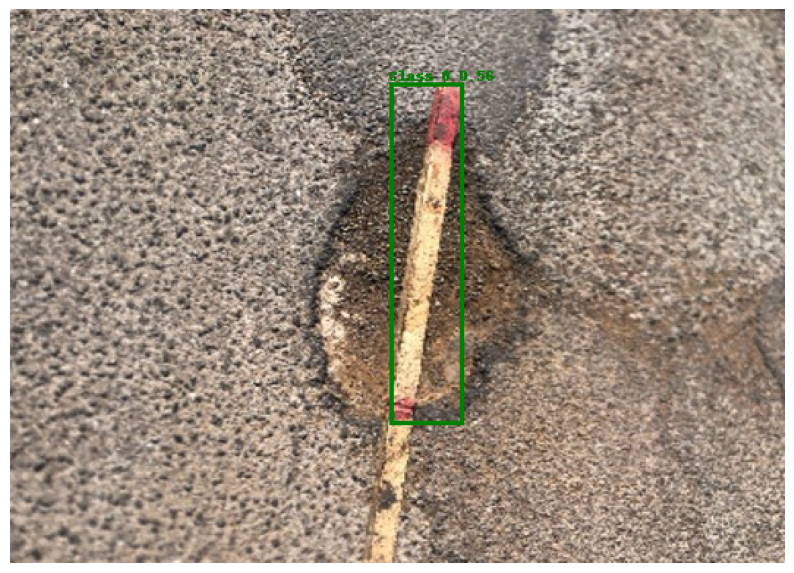

In [9]:
def sample_and_predict(model, images):
    """
    Randomly sample an image, predict the bounding boxes, and plot the image with the predicted boxes using PIL.
    
    Args:
    - model: Trained YOLOv8 model.
    - images: DataFrame containing images and their associated IDs.
    """
    
    # Randomly sample an image
    sample_row = images.sample(1).iloc[0]
    image = sample_row['image']
    pothole_id = sample_row['pothole_id']
    
    # Run prediction
    results = model.predict(source=image, save=False)
    
    # Extract the predictions
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores
    classes = results[0].boxes.cls.cpu().numpy()  # Class labels
    
    # Convert image to PIL format
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)
    
    for box, confidence, class_id in zip(boxes, confidences, classes):
        x1, y1, x2, y2 = box.astype(int)
        label = f'Class {int(class_id)} {confidence:.2f}'
        
        # Draw bounding box
        draw.rectangle([(x1, y1), (x2, y2)], outline="green", width=3)
        
        # Draw label
        draw.text((x1, y1 - 10), label, fill="green")
    
    # Plot the image with bounding boxes using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

# Usage example:
sample_and_predict(model, test_images)